# Full Name:  Çağdaş Güven


# Student ID: 2738938

# Find words of certain patterns: Scrabble with ME536 flavor
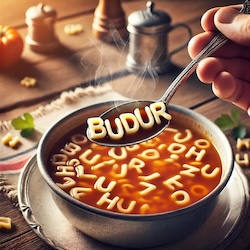


# as usual, start with imports

You are not allowed to import additional libraries, but you can import other sub-libraries for conveinence

In [4]:
# import usual suspects
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as pimg # check this out this is new
from numpy import cos, arccos, sin, pi, round
from numpy.linalg import matrix_rank as rank
from numpy.linalg import svd, eig
from scipy.linalg import orth
from scipy.ndimage import convolve
import cv2 as cv
from skimage import io
from skimage.filters import threshold_otsu as otsu
from PIL import Image, ImageDraw, ImageFont
from PIL import Image # if needed more can be importaed
import sklearn as skl # famous sci-kit learn
import skimage as ski # equally famous sci-kit image
!rm bug_numpy_utils.py 2>/dev/null  # at the first run file does not exits but error should print
!wget https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/bug_numpy_utils.py
from bug_numpy_utils import MatPrint, CData, text2mat # note that once these files are downloaded you can read their content.
from bug_numpy_utils import DrawOnImage as DrawIt
!rm me536utils.py 2>/dev/null  # at the first run file does not exits but error should print
!wget https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/me536utils.py
from me536utils import RotMat

# my imports
from scipy.spatial import ConvexHull
from skimage.measure import label, regionprops

--2025-01-03 20:31:19--  https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/bug_numpy_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18456 (18K) [text/plain]
Saving to: ‘bug_numpy_utils.py’

bug_numpy_utils.py  100%[===================>]  18.02K  --.-KB/s    in 0.005s  

2025-01-03 20:31:19 (3.38 MB/s) - ‘bug_numpy_utils.py’ saved [18456/18456]

--2025-01-03 20:31:19--  https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/me536utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3130 (3.1K

## Let's get started with generating a test image
Test images to functions you will write can be generated using the following code.  

Some of the paramters will not change, yet play with the changable parameters to see what kind of different images can be generated with it.  

Note that at the end a __box__ and a __line__ is also drawn on the image to demonstrate the usage of already provided (imported) function: ```DrawIt()```.

So all utilities are already provided, so that you can focus on the tast itself!

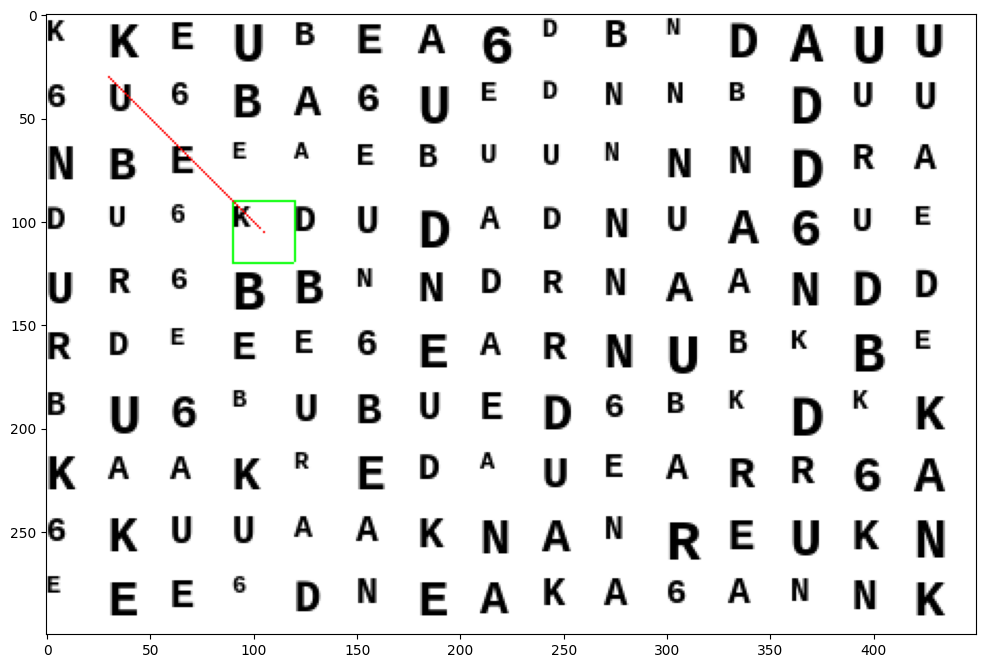

In [3]:
# in the assignment assessment following will not change in test images
fontname = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
cellSize = 30 #cell within which a single char will be printed
BackColor = (255,255, 255) # back color
ForeColor = (0, 0, 0) # font color

charz = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
#charz = ['R' ]
# in the assignment assessment variable above will not change in generating test images

# CHANGABLE PARAMETER
xCount, yCount = 15, 10 # number of cells

# prompt: generate a list that is 10 by 15 that that contains * in each element
charmap = [['' for i in range(xCount)] for j in range(yCount)] # assign
# '''
# The following is to be used in generating the resulting image in your function
# Note that you will need more colors, and location of lines and boxes will be determined by your function
# '''
# # generate 2 sample pens
# penRed = (255,0, 0)
# penGreen = (0,255,0)

# # a green box with no diagonals
# img = DrawIt(img, ((90, 90),(120, 120)), box=True, diagonals = False, dpen=penGreen)
# # finally a blue line
# img = DrawIt(img, ((30, 30),(105, 105)), dpen = penRed)



# # finally plot the image
# plt.figure(figsize=(12,9))
# plt.imshow(img)

# CHANGABLE PARAMETER
numLetters = 1500 #well obvious

# CHANGABLE PARAMETER
fixedFontSize = False #if variable font size will be used

fR = 0.8 # font ratio to cell size
fontsize = int(cellSize * fR) # fixed font size
nB = int(cellSize*(1-fR)) # location noise

img = Image.new('RGB', (xCount*cellSize,yCount*cellSize), BackColor ) # blank image
imgPen = ImageDraw.Draw(img) # pen to draw on the blank image

pos = [] # keep track of occupied cells
for i in range(numLetters): # draw each letter if random location is not already occupied, if occupied, skip
    if not fixedFontSize: # if set so, select a random font size
        fontsize = np.random.randint(12, cellSize-1)
        dx, dy = 0, 0 # when scaled, position does not change
    else: # add some location noise
        dx = int(np.random.rand()* nB)
        dy = int(np.random.rand()* nB)
    font = ImageFont.truetype(fontname, fontsize) # font instace created
    txt = random.choice(charz)
    x = np.random.randint(0, xCount)
    y = np.random.randint(0, yCount)
    if (x,y) not in pos:
        imgPen.text((x * cellSize + dx, y * cellSize + dy), txt, font=font, fill=ForeColor) # write the character to blank image
        pos.append((x,y))

img = np.array(img) # convert PIL image to numpy for future numpy stuff, this is what I will pass to your function



'''
The following is to be used in generating the resulting image in your function
Note that you will need more colors, and location of lines and boxes will be determined by your function
'''
# generate 2 sample pens
penRed = (255,0, 0)
penGreen = (0,255,0)

# a green box with no diagonals
img = DrawIt(img, ((90, 90),(120, 120)), box=True, diagonals = False, dpen=penGreen)
# finally a blue line
img = DrawIt(img, ((30, 30),(105, 105)), dpen = penRed)



# finally plot the image
plt.figure(figsize=(12,9))
plt.imshow(img)


# Your assignment starts here

You are to write 1 function to which an image generated by the code above will be passed along with one of the following words: "KARE", "BUDUR" and "6KENAR".  
Note that all letters will be upper case.  

The stub of the function you are to complete is given below.  

If **KARE** is pased, your function at the end should:  
- Change the colors (i.e. 4 different colors in total) of all the letters in "KARE" for all instances of letters 'K', 'A', 'R' and 'E' so that we can see that your algorithm was able to find all relevant letters.
- Select the 4 letters 'K', 'A', 'R' and 'E' in a row, draw a fixed colored box around the selected letters and connect their centers with lines, so that when you follow the letters from 'K' to 'E' it should look like the best possible square within the given image. When connecting letters, finally connect 'E' to 'K' so that it properly looks like a polygon.

If **BUDUR** is passed, your function should:
- Similarly, change the colors (i.e. 5 differen colors in total) of all letters in "BUDUR" for all instances of 'B', 'U', 'D', 'U' and 'R'.  
- This time, you are trying to find the shortest path that connects the letters of the word "BUDUR". Once sequence is found, similarly put a colored box around all 6 letters and connect them with lines from 'B' all the way to 'R'.  Do not connect 'R' back to 'B', since this is a path.

If **6KENAR** is passed, your function should:
- Well, same deal goes on, change the colors of (i.e. 6 differen colors in total) of all '6', 'K', 'E', 'N', 'A' and 'R' for the same reason as above.
- Select the characters in such a way that, after placing 6 colored boxed and drawing 6 lines as define above, when the centers of the boxes from '6' all the way to 'R' and back to '6' are connected, it should be the largest possile 6 sided [convex polygon](https://mathworld.wolfram.com/ConvexPolygon.html) (irregular convex hexagon) within the given image. In other words, you are not looking for a perfect, i.e. equilateral hexagon, but any convex 6 sided polygon with the largest area is what you are looking for.

Note that in all of the above cases, letters should be sorted. For example if the solution is given for 'BUDUR', Starting from letter 'B' if we follow the lines one after the other, we shoul visit 'U', 'D', 'U' and 'R'. The others are similar. So order matters!!!

Also note that for 'KARE' and '6KENAR' I expect you to explain clearly what measure you use and how you select the best fitting alternative.

If the passes string cannot be formed using the letters in the passed image (for example assume that letter 'E', does not exist at all, and passes text is "6KENAR"), then your code should seperately color all remaining letters in the image, i.e. all '6', 'K', 'N', 'A' and 'R' letters should be colored, different letters, different colors, same letters same color.

You are expected to fill in the ```SearchInAlphabetSoup()``` function, yet you can write as many support functions you like below, but at the end please put all your code in **ONE CODE CELL** so that we can start testing your code after running only the following cell.

## Explanation of how to solve 'KARE' case:  

The `DrawSquareFromText_NoCollision_WithBoxes` function finds the best configuration of four points that form a square-like shape while ensuring that the edges do not collide with each other. Here's a simple breakdown:

So I handle KARE with DrawSquareFromText_NoCollision_WithBoxes function where I take necessary locations of the letters and iterate through all possible combinations of four points. I watch if edges collide, try to find similar lengths of edges, similar angles, and so on. I rank the combinations based on these criteria and select the best one.

---

### 1. **Inputs and Outputs**
- **Inputs:**
  - `img`: The image to process.
  - `txt`: A string of four characters (e.g., `"KARE"`).
  - `addresses`: A dictionary containing the grid coordinates of detected letters.
  - `cell_size`: The size of each cell in the grid.
- **Output:**
  - An image with a square connecting the selected points, colored and highlighted.

---

### 2. **Steps in the Algorithm**

#### **a. Extract Cell Centers**
For each letter in `txt`, we compute the **center coordinates** of all detected instances in the grid. These are the candidate points to form the square.

#### **b. Measure for "Square-Like" Shape**
To decide which four points form the best square-like shape, we consider:
1. **Angles:** The four angles at the corners of the square should ideally be **90°**.
2. **Edge Lengths:** The four edges of the square should have similar lengths.

---

#### **c. Edge Intersection Check**
We ensure that the edges connecting the points:
- Do not **collide** with each other (using the `edges_intersect` function).

---

#### **d. Scoring the Candidates**
For every combination of one point per letter (total possibilities = $N_K \times N_A \times N_R \times N_E$):
1. Calculate the **angles** at all four corners.
2. Compute the **mean angle deviation** from 90°.
3. Compute the **standard deviation of edge lengths**.
4. Calculate a **score** combining:
   $
   \text{Score} = |\text{Mean Angle} - 90^\circ| + \text{Edge Length Deviation}
   $
   Lower scores are better.

---

### 3. **Selecting the Best Fit**
- Iterate through all combinations of the four points.
- Skip configurations where edges intersect.
- Choose the configuration with the **lowest score**.

---

### 4. **Drawing the Result**
1. Draw the square using the selected points.
2. Highlight the cells containing the selected letters:
   - Draw a **box** around each cell.
   - Change the **color of the letters** to orange by detecting non-white regions in the cell.

---

### Key Concepts

- **Angle Calculation:**
   $
   \theta = \arccos \left( \frac{\vec{u} \cdot \vec{v}}{\|\vec{u}\| \|\vec{v}\|} \right)
   $
   where $ \vec{u} $ and $ \vec{v} $ are vectors representing adjacent edges.

- **Edge Length Calculation:**
   $
   L = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
   $

- **Scoring System:**
   - Minimize deviation from $90^\circ$ for angles.
   - Minimize differences in edge lengths for uniformity.

---

### 5. **Why This Works**
- **Angles and lengths ensure geometric similarity:** The function prioritizes configurations that are visually square-like.
- **Collision prevention ensures validity:** By skipping intersecting configurations, the function guarantees a clean, non-overlapping square.

---

### Example
Given `txt="KARE"`:
1. Calculate centers of all detected $ K, A, R, E $ cells.
2. Try all combinations (one $ K $, one $ A $, one $ R $, one $ E $).
3. Skip intersecting edges.
4. Choose the configuration that minimizes angle deviation and edge length differences.
5. Draw the result on the image.

This approach is robust, ensuring the best possible square from the available points while avoiding visual artifacts or collisions. Although since I am countouring one more time I think it would be best to implement some preprocessing for received image quality. But we are focused on the speed of the algorithm.

## Explanation of how to solve the '6KENAR' case:  

The `BiggestHexagon` function is designed to find the largest convex hexagon (based on area) that can be formed by selecting one vertex for each of the six specified letters. The algorithm ensures that:

1. **Convexity:** The hexagon must be convex, meaning all interior angles are less than 180°.
2. **Edge Collision-Free:** No two edges of the hexagon should intersect, ensuring a valid polygon.
3. **Maximized Area:** The algorithm prioritizes finding the hexagon configuration with the largest area.

---

### Key Steps in the Function:

1. **Extract Centers:**
   - For each letter in the input text (`txt`), all potential cell centers are computed based on the grid's `cell_size`. These centers represent candidate vertices for the hexagon.

   ```python
   centers = {char: [get_cell_center(cell) for cell in addresses[char]] for char in txt}
   ```

2. **Prioritize Edge-Aligned Vertices:**
   - The first four vertices are selected by prioritizing those closest to the image edges. This heuristic reduces the search space and ensures better initial configurations for the hexagon.

   ```python
   sorted_vertices = sorted(centers[char], key=lambda p: distance_from_edges(p, img_width, img_height))
   initial_candidates.append(sorted_vertices)
   ```

3. **Iterative Area Maximization:**
   - Starting with the first four vertices (aligned to edges), the function iterates over possible combinations of the last two vertices. It checks all combinations for:
     - **Convexity:** Ensures the hexagon remains a valid convex polygon.
     - **Edge Collision-Free:** Ensures no edge intersections.

   ```python
   for fifth in centers[txt[4]]:
       for sixth in centers[txt[5]]:
           candidate = polygon + [fifth, sixth]

           if not is_convex(candidate):
               continue

           collision = any(
               edges_intersect(candidate[i], candidate[(i + 1) % len(candidate)],
                               candidate[j], candidate[(j + 1) % len(candidate)])
               for i in range(len(candidate)) for j in range(i + 1, len(candidate))
           )
           if collision:
               continue
   ```

4. **Maximize Area:**
   - The function calculates the area for valid configurations using the **Shoelace formula**. It updates the `best_hexagon` and `max_area` when a larger area is found.

   ```python
   area = polygon_area(candidate)
   if area > max_area:
       max_area = area
       best_hexagon = candidate
   ```

5. **Draw the Hexagon:**
   - The selected hexagon is drawn on the image using:
     - **Edges:** Drawn between adjacent vertices.
     - **Cells:** Highlighted with a bounding box.
     - **Contours:** Color masking applied to the non-white regions within the cells.

   ```python
   for i in range(len(best_hexagon)):
       img_with_hexagon = DrawIt(
           img_with_hexagon,
           (best_hexagon[i], best_hexagon[(i + 1) % len(best_hexagon)]),
           box=False,
           diagonals=False,
           dpen=(255, 0, 255),
       )
   ```

---

### Complexity Analysis:

#### Original Approach:
The Cartesian product of all six sets of vertices has complexity $ O(n_1 \cdot n_2 \cdot n_3 \cdot n_4 \cdot n_5 \cdot n_6) $, which is exponential and infeasible for large grids.

#### Optimized Approach:
1. **Edge Prioritization:**
   - The first four vertices are sorted and selected based on their distance from the image edges. This reduces the initial search space to a manageable size.
2. **Iterative Refinement:**
   - The last two vertices are added iteratively to maximize the hexagon's area, ensuring that unnecessary configurations are skipped.

#### Complexity:
While the complexity is still influenced by the number of vertices in each set, the heuristic significantly reduces the number of iterations, effectively behaving closer to $ O(n \cdot m^2) $, where:
- $ n $: Average number of vertices per letter.
- $ m $: Number of iterations to refine the last two vertices.

---

### Potential Improvements:

1. **Parallel Computation:**
   - Utilize multi-threading or GPU-based libraries like TensorFlow or PyTorch to compute areas and check convexity/collisions in parallel for multiple configurations.

2. **Geometric Heuristics:**
   - Instead of iterating over all possible fifth and sixth vertices, using heuristics like:
     - Favoring vertices closer to the centroid of the initial four vertices.
     - Penalizing configurations that deviate significantly from regular hexagon proportions.

3. **Convex Hull Techniques:**
   - Pre-computing a convex hull of the combined vertices and select subsets that maintain convexity directly.

---

This optimized heuristic balances computational complexity with accuracy, ensuring feasible performance even for moderate grid sizes.

In [5]:
# all of your support code in this box... in case needed


def DrawSquareFromText_NoCollision_WithBoxes(img, txt, addresses, cell_size=30):
    """
    Draw a square connecting the centers of the cells containing the characters in the given text,
    ensuring angles are close to 90 degrees, edges do not collide, and edge lengths are close.

    Args:
        img (ndarray): Input image.
        txt (str): Text to draw the square for (e.g., "KARE").
        addresses (dict): Dictionary of detected letter addresses.
        cell_size (int): Size of each cell in the grid.

    Returns:
        img_with_square (ndarray): Image with the square drawn.
    """
    # Helper function to calculate cell center
    def get_cell_center(cell):
        return (cell[1] * cell_size + cell_size // 2, cell[0] * cell_size + cell_size // 2)

    # Helper function to calculate distance between two points
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    # Helper function to check edge intersection
    def edges_intersect(p1, p2, q1, q2):
        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])

        return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

    # Extract centers for each character in the text
    centers = {char: [get_cell_center(cell) for cell in addresses[char]] for char in txt}

    # If any character is not detected, return the original image
    if any(len(centers[char]) == 0 for char in txt):
        print(f"Error: One or more characters in {txt} are not detected.")
        return img

    # Find the best configuration of cell centers that form a square
    best_square = None
    best_score = float('inf')

    for k_center in centers[txt[0]]:
        for a_center in centers[txt[1]]:
            for r_center in centers[txt[2]]:
                for e_center in centers[txt[3]]:
                    # Calculate angles for all corners
                    angle_k = calculate_angle(e_center, k_center, a_center)
                    angle_a = calculate_angle(k_center, a_center, r_center)
                    angle_r = calculate_angle(a_center, r_center, e_center)
                    angle_e = calculate_angle(r_center, e_center, k_center)

                    # Check for edge collisions
                    if edges_intersect(k_center, a_center, r_center, e_center):
                        continue
                    if edges_intersect(a_center, r_center, e_center, k_center):
                        continue

                    # Calculate edge lengths
                    edges = [
                        distance(k_center, a_center),
                        distance(a_center, r_center),
                        distance(r_center, e_center),
                        distance(e_center, k_center),
                    ]
                    edge_deviation = np.std(edges)  # Variation in edge lengths

                    # Check if angles are close to 90 degrees and edges are similar in length
                    angles = [angle_k, angle_a, angle_r, angle_e]
                    mean_angle = np.mean(angles)
                    angle_deviation = np.std(angles)  # Variation between angles
                    score = abs(mean_angle - 90) + angle_deviation + edge_deviation

                    if score < best_score:
                        best_score = score
                        best_square = (k_center, a_center, r_center, e_center)

    if best_square:
        # Draw the square and highlight chosen cells
        img_with_square = img.copy()

        # Draw the square
        img_with_square = DrawIt(img_with_square, (best_square[0], best_square[1]), box=False, diagonals=False, dpen=(255, 0, 0))
        img_with_square = DrawIt(img_with_square, (best_square[1], best_square[2]), box=False, diagonals=False, dpen=(0, 255, 0))
        img_with_square = DrawIt(img_with_square, (best_square[2], best_square[3]), box=False, diagonals=False, dpen=(0, 0, 255))
        img_with_square = DrawIt(img_with_square, (best_square[3], best_square[0]), box=False, diagonals=False, dpen=(255, 255, 0))

        # Highlight the selected cells and color the letters
        for center in best_square:
            # Calculate the bounding box for the current cell
            top_left = (center[0] - cell_size // 2, center[1] - cell_size // 2)
            bottom_right = (center[0] + cell_size // 2, center[1] + cell_size // 2)

            # Ensure the coordinates are within the image bounds
            top_left = (max(0, top_left[1]), max(0, top_left[0]))
            bottom_right = (min(img_with_square.shape[1] - 1, bottom_right[1]), min(img_with_square.shape[0] - 1, bottom_right[0]))

            # Draw the box around the cell
            box_coords = (top_left[::-1], bottom_right[::-1])
            img_with_square = DrawIt(img_with_square, box_coords, box=True, diagonals=False, dpen=(0, 165, 255))

            # Apply the orange mask for the letter region
            cell_region = img_with_square[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
            gray_cell = cv.cvtColor(cell_region, cv.COLOR_BGR2GRAY)
            _, binary_cell = cv.threshold(gray_cell, 240, 255, cv.THRESH_BINARY_INV)  # Extract non-white regions

            # Find contours in the binary cell region
            contours, _ = cv.findContours(binary_cell, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                cv.drawContours(cell_region, [contour], -1, (0, 165, 255), thickness=cv.FILLED)
        img_with_square = cv.cvtColor(img_with_square, cv.COLOR_BGR2RGB)
        return img_with_square

    print("No valid square configuration found.")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def calculate_angle(p1, p2, p3):
    """
    Calculate the angle formed by three points (p1 -> p2 -> p3).

    Args:
        p1, p2, p3 (tuple): Points as (x, y).

    Returns:
        angle (float): Angle in degrees.
    """
    # Vectors
    v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
    v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])

    # Calculate the angle
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip for numerical stability
    return np.degrees(angle)


def FindShortestPath(img, txt, addresses, cell_size=30):
    """
    Find the shortest path connecting the letters in the given text in the specified order.
    Avoids colliding edges by retrying with excluded paths.
    """

    def euclidean_distance(cell1, cell2):
        x1, y1 = cell1
        x2, y2 = cell2
        return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    def get_cell_center(cell):
        return (cell[1] * cell_size + cell_size // 2, cell[0] * cell_size + cell_size // 2)

    def edges_intersect(p1, p2, q1, q2):
        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])
        return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

    img_with_path = img.copy()
    colliding_edges = []
    path = []

    while True:
        current_position = None
        visited = set()
        path.clear()

        for char in txt:
            if not addresses[char]:
                print(f"Error: Character {char} not detected.")
                return img

            if current_position is None:
                closest_cell = min(addresses[char], key=lambda cell: 0)
            else:
                valid_cells = [
                    cell
                    for cell in addresses[char]
                    if cell not in visited
                    and not any(
                        edges_intersect(
                            get_cell_center(current_position),
                            get_cell_center(cell),
                            edge[0],
                            edge[1]
                        )
                        for edge in colliding_edges
                    )
                ]
                if not valid_cells:
                    print(f"No valid path found for character {char}. Retrying...")
                    break

                closest_cell = min(valid_cells, key=lambda cell: euclidean_distance(current_position, cell))

            path.append(closest_cell)
            visited.add(closest_cell)
            current_position = closest_cell

        if len(path) == len(txt):
            break

        if path and len(path) > 1:
            # Add the colliding edge to the list of excluded edges
            for i in range(len(path) - 1):
                colliding_edges.append((get_cell_center(path[i]), get_cell_center(path[i + 1])))

    # Draw the path
    for i in range(len(path) - 1):
        start = get_cell_center(path[i])
        end = get_cell_center(path[i + 1])
        img_with_path = DrawIt(img_with_path, (start, end), box=False, diagonals=False, dpen=(0, 255, 0))

    # Highlight the chosen cells
    for cell in path:
        top_left = (cell[1] * (cell_size), cell[0] * (cell_size))
        bottom_right = ((cell[1] + 1) * (cell_size), (cell[0] + 1) * (cell_size))
        # Ensure the coordinates are within the image bounds
        top_left = (max(0, top_left[1]), max(0, top_left[0]))
        bottom_right = (min(img_with_path.shape[1] - 1, bottom_right[1]), min(img_with_path.shape[0] - 1, bottom_right[0]))
        # Clip coordinates to image dimensions
        top_left = (max(0, min(top_left[0], img_with_path.shape[1] - 1)), max(0, min(top_left[1], img_with_path.shape[0] - 1)))
        bottom_right = (max(0, min(bottom_right[0], img_with_path.shape[1] - 1)), max(0, min(bottom_right[1], img_with_path.shape[0] - 1)))

        # Draw the box
        box_coords = (top_left[::-1], bottom_right[::-1])
        img_with_path = DrawIt(img_with_path, box_coords, box=True, diagonals=False, dpen=(255, 0, 0))

        # Apply the orange mask for the letter region
        cell_region = img_with_path[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        gray_cell = cv.cvtColor(cell_region, cv.COLOR_BGR2GRAY)
        _, binary_cell = cv.threshold(gray_cell, 240, 255, cv.THRESH_BINARY_INV)
        contours, _ = cv.findContours(binary_cell, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            cv.drawContours(cell_region, [contour], -1, (0, 165, 255), thickness=cv.FILLED)
    img_with_path = cv.cvtColor(img_with_path, cv.COLOR_BGR2RGB)
    return img_with_path

def euclidean_distance(p1, p2):
    """
    Calculate the Euclidean distance between two points.

    Args:
        p1 (tuple): First point (x1, y1).
        p2 (tuple): Second point (x2, y2).

    Returns:
        float: Euclidean distance between p1 and p2.
    """

    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def BiggestHexagon(img, txt, addresses, cell_size=30):
    """
    Create the largest convex hexagon connecting the centers of the cells containing the characters in the given text,
    ensuring edges do not collide and the polygon is convex.
    Priority is given to the first four vertices being closest to image edges,
    while the last two vertices aim to maximize the polygon area.

    Args:
        img (ndarray): Input image.
        txt (str): Text to form the hexagon (e.g., "6KENAR").
        addresses (dict): Dictionary of detected letter addresses.
        cell_size (int): Size of each cell in the grid.

    Returns:
        img_with_hexagon (ndarray): Image with the hexagon drawn.
    """

    # Helper function to calculate cell center
    def get_cell_center(cell):
        return (cell[1] * cell_size + cell_size // 2, cell[0] * cell_size + cell_size // 2)

    # Helper function to calculate distance from image edges
    def distance_from_edges(point, img_width, img_height):
        x, y = point
        return min(x, y, img_width - x, img_height - y)

    # Helper function to calculate the area of a polygon
    def polygon_area(vertices):
        x, y = zip(*vertices)
        return 0.5 * abs(sum(x[i] * y[i + 1] - y[i] * x[i + 1] for i in range(-1, len(vertices) - 1)))

    # Helper function to check if a polygon is convex
    def is_convex(vertices):
        def cross_product(o, a, b):
            return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

        signs = [cross_product(vertices[i], vertices[(i + 1) % len(vertices)], vertices[(i + 2) % len(vertices)]) for i in range(len(vertices))]
        return all(s >= 0 for s in signs) or all(s <= 0 for s in signs)

    # Helper function to check edge intersection
    def edges_intersect(p1, p2, q1, q2):
        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])

        return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

    # Extract centers for each character in the text
    centers = {char: [get_cell_center(cell) for cell in addresses[char]] for char in txt}

    # If any character is not detected, return the original image
    if any(len(centers[char]) == 0 for char in txt):
        print(f"Error: One or more characters in {txt} are not detected.")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        return img

    # Initialize variables
    img_height, img_width = img.shape[:2]
    best_hexagon = None
    max_area = 0

    # Find initial four vertices closest to image edges
    initial_candidates = []
    for i, char in enumerate(txt[:4]):
        sorted_vertices = sorted(centers[char], key=lambda p: distance_from_edges(p, img_width, img_height))
        initial_candidates.append(sorted_vertices)

    # Iterate over initial four vertices combinations
    for first in initial_candidates[0]:
        for second in initial_candidates[1]:
            for third in initial_candidates[2]:
                for fourth in initial_candidates[3]:
                    polygon = [first, second, third, fourth]
                    
                    # Iterate over combinations of the last two vertices
                    for fifth in centers[txt[4]]:
                        for sixth in centers[txt[5]]:
                            candidate = polygon + [fifth, sixth]

                            # Check if the polygon is convex and has no edge collisions
                            if not is_convex(candidate):
                                continue
                            collision = any(
                                edges_intersect(candidate[i], candidate[(i + 1) % len(candidate)],
                                                candidate[j], candidate[(j + 1) % len(candidate)])
                                for i in range(len(candidate)) for j in range(i + 1, len(candidate))
                            )
                            if collision:
                                continue

                            # Calculate area
                            area = polygon_area(candidate)
                            if area > max_area:
                                max_area = area
                                best_hexagon = candidate

    if best_hexagon:
        # Draw the hexagon and highlight chosen cells
        img_with_hexagon = img.copy()

        # Draw the edges of the hexagon
        for i in range(len(best_hexagon)):
            img_with_hexagon = DrawIt(
                img_with_hexagon,
                (best_hexagon[i], best_hexagon[(i + 1) % len(best_hexagon)]),
                box=False,
                diagonals=False,
                dpen=(255, 0, 255),
            )

        # Highlight the chosen cells and change the colors of the letters
        for center in best_hexagon:
            # Calculate the bounding box for the current cell
            top_left = (center[0] - cell_size // 2, center[1] - cell_size // 2)
            bottom_right = (center[0] + cell_size // 2, center[1] + cell_size // 2)

            # Ensure the coordinates are within the image bounds
            top_left = (max(0, top_left[1]), max(0, top_left[0]))
            bottom_right = (
                min(img_with_hexagon.shape[1] - 1, bottom_right[1]),
                min(img_with_hexagon.shape[0] - 1, bottom_right[0]),
            )

            # Draw the box around the cell
            box_coords = (top_left[::-1], bottom_right[::-1])
            img_with_hexagon = DrawIt(
                img_with_hexagon, box_coords, box=True, diagonals=False, dpen=(0, 255, 255)
            )

            # Apply the orange mask for the letter region
            cell_region = img_with_hexagon[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
            gray_cell = cv.cvtColor(cell_region, cv.COLOR_BGR2GRAY)
            _, binary_cell = cv.threshold(gray_cell, 240, 255, cv.THRESH_BINARY_INV)
            contours, _ = cv.findContours(binary_cell, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                cv.drawContours(cell_region, [contour], -1, (0, 165, 255), thickness=cv.FILLED)

        img_with_hexagon = cv.cvtColor(img_with_hexagon, cv.COLOR_BGR2RGB)
        return img_with_hexagon

    print("No valid hexagon configuration found.")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img



In [7]:
# We will only call the following funciton
def SearchInAlphabetSoup(img, txt = 'KARE'):
    '''
    Inputs:
        img: an image generated as shown in the relevant code block is the input
        txt: it will have either of these values ('KARE', 'BUDUR', '6KENAR')
            default is 'KARE', or if txt is something invalid
    Outputs:
        The function goes over the letters in img and returns the processed image
        The processing will depend on the content of txt. The function will try to
        find a sequence of letters that spell the content of txt such that,
        if txt =
            'KARE': 4 letters when connected in correct order in the image, forms the best possible square
            'BUDUR': shortest path that spells BUDUR in the image
            '6KENAR': 6 characters when connected in correct order in the image, forms the largest possible 6 sided polygon that is convex yet not necessarily equilateral
        is selected.
        There will be a box around each letter and lines connecting consequitive boxes as explained above
        where the selected letters inside the boxes are also colored distinctively

        If passed word does not exist in the image at all, remaining letters should be colored distinctively as explained above
    '''
    # Reference Hu moments for known characters (if not provided externally)
    reference_hu_moments=None

    if reference_hu_moments is None:
        reference_hu_moments = {
            'R': [
            [2.99337424, 7.37441974, 11.49610793, 11.15684756, -12., 11.99959664, -12.],
            [2.99819389, 7.18990667, 11.37563441, 11.15438167, 12., 11.99955274, -12.],
            [3.00293021, 7.23328647, 11.60703302, 11.20708134, -12., 11.99949215, -12.],
            [3.02180598, 7.49264423, 11.06654149, 11.05402679, 12., 11.99981334, -12.],
            [2.95856174, 7.2228826, 11.19475844, 11.13353714, -12., 11.99933721, -12.],
            [3.02180598, 7.49264423, 11.06654149, 11.05402679, 12., 11.99981334, -12.],
            [2.97116618, 7.05089972, 10.90547477, 10.88396242, 12., 11.99870308, -12.],
            [2.98172651, 7.44007234, 11.43527447, 10.98473779, 12., 11.99947495, -12.],
            [2.97116618, 7.05089972, 10.90547477, 10.88396242, 12., 11.99870308, -12.],
            [2.9861125, 7.22016021, 11.15788965, 11.20814166, 12., 11.99979985, -12.]
    ],
            'B': [
            [3.00640564, 7.17381556, 10.98021093, 11.86583584, -12., 11.99996283, 12.],
            [2.9731605, 6.94182847, 11.02548256, 11.78251691, -12., 11.99990488, 12.],
            [2.99780934, 7.01905498, 11.07342144, 11.90761205, -12., 11.99996904, 12.],
            [2.98469476, 7.05281015, 10.80878881, 11.9772553, -12., -11.99999372, -12.],
            [2.99330435, 7.01698556, 10.82322186, 11.75383154, 12., 11.9999893, -12.],
            [2.99330435, 7.01698556, 10.82322186, 11.75383154, 12., 11.9999893, -12.],
            [3.0192444, 7.4303944, 10.9420488, 11.68960313, 12., -11.99991294, 12.],
            [3.01209861, 7.02534156, 10.91654653, 11.84651875, 12., 11.99998056, 12.],
            [3.0041089, 7.20432312, 10.91756631, 11.84952106, -12., 11.99996271, -12.],
            [2.98051719, 7.22155248, 10.93982636, 11.49273447, -12., 11.99996089, -12.]
    ],
            'U': [
            [2.9161667, 7.31809027, 10.24799455, 10.8103928, -12., 11.99862494, -12.],
            [2.9161667, 7.31809027, 10.24799455, 10.8103928, -12., 11.99862494, -12.],
            [2.9161667, 7.31809027, 10.24799455, 10.8103928, -12., 11.99862494, -12.],
            [2.94840854, 7.64026168, 10.13563288, 10.7562245, -12., 11.99964574, 12.],
            [2.93660685, 7.30327783, 10.27246636, 10.68193869, 12., 11.99970407, 12.],
            [2.91076294, 7.20722672, 10.17176905, 10.64430474, -12., 11.99766965, -12.],
            [2.93318599, 7.03895723, 10.39722718, 10.80500237, -12., 11.99906914, -12.],
            [2.91076294, 7.20722672, 10.17176905, 10.64430474, -12., 11.99766965, -12.],
            [2.91076294, 7.20722672, 10.17176905, 10.64430474, -12., 11.99766965, -12.],
            [2.9497132, 7.13331803, 10.36393817, 11.14940597, -12., 11.99928372, -12.]
    ],
            'D': [
            [2.9084599, 6.96149022, 10.0521984, 11.30194296, -12., -11.99944716, -12.],
            [2.95753146, 7.01708874, 10.22160862, 11.46446138, -12., -11.99970016, 12.],
            [2.98530048, 7.13249677, 10.36855768, 11.82979516, 12., -11.99994343, 0.],
            [2.98530048, 7.13249677, 10.36855768, 11.82979516, 12., -11.99994343, 0.],
            [2.98530048, 7.13249677, 10.36855768, 11.82979516, 12., -11.99994343, 0.],
            [2.94111029, 7.12690735, 10.19089953, 11.87114148, 12., 11.99998115, -12.],
            [2.92340801, 6.86960773, 10.131772, 11.60386621, -12., -11.99976977, -12.],
            [2.92340801, 6.86960773, 10.131772, 11.60386621, -12., -11.99976977, -12.],
            [2.98932668, 7.20351484, 10.30523049, 11.88963167, -12., -11.99996856, -12.],
            [2.95644284, 7.15427152, 10.15573452, 11.979795, -12., 11.99999951, 12.]
    ],
            'K': [
            [2.97521928, 7.14191947, 10.33176639, 10.6614037, -12., -11.99765613, 12.],
            [2.97521928, 7.14191947, 10.33176639, 10.6614037, -12., -11.99765613, 12.],
            [2.97521928, 7.14191947, 10.33176639, 10.6614037, -12., -11.99765613, 12.],
            [3.00113588, 7.34264773, 10.59911877, 10.58052349, -12., -11.99769337, 12.],
            [2.95769602, 7.10405808, 10.02161954, 10.56740793, -12., -11.99702514, 12.],
            [2.97171965, 6.99304696, 10.26616856, 10.73675528, -12., -11.99764933, 12.],
            [3.00113588, 7.34264773, 10.59911877, 10.58052349, -12., -11.99769337, 12.],
            [2.96010755, 6.94906786, 10.11911532, 10.62768259, -12., -11.99672589, 12.],
            [2.95623471, 7.13358849, 10.4803107, 10.51900689, -12., -11.99672277, 12.],
            [3.00476809, 7.08902742, 10.60881822, 10.79691926, -12., -11.99817015, 12.]
    ],
     #aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


            'A': [
            [  2.96356354  , 7.27730944  , 9.15974507 , 11.1055351  ,-12. , 11.99932451 , 12.        ],
            [  2.96356354 ,  7.27730944  , 9.15974507 , 11.1055351 , -12. , 11.99932451 , 12.        ],
            [  2.96766208 ,  7.25726     , 9.20516206 , 11.23301135 ,-12. , 11.99950535 , 12.        ],
            [  2.9619816  ,  7.26473138  , 9.18647435 , 11.16697955 ,-12. , 11.99941747 , 12.        ],
            [  2.94737101  , 7.17711621  , 9.20230938 , 10.79720977 ,-12. , 11.99833304 , 12.        ],
            [  2.94737101  , 7.17711621  , 9.20230938  ,10.79720977 ,-12. , 11.99833304 , 12.        ],
            [  2.94737101 ,  7.17711621  , 9.20230938 , 10.79720977 ,-12. , 11.99833304 , 12.        ],
            [  2.9987038  ,  7.36524797  , 9.28425017 , 11.46253624 ,-12. , 11.99977935 ,-12.        ],
            [ 2.99393918 , 7.37770734 , 9.23595474, 11.01256409 ,12.    ,     11.99947822 ,12.       ],
            [  2.96838801  , 7.16479765   ,9.23708667  ,11.0499672  ,-12. , 11.9991497  , 12.        ]
    ],
            # eeeeeeeeeeeeeeeeeeeeeeeeee
            'E':[
            [  2.90148216  , 6.61715167  ,10.23203413  ,10.33271991 ,-12., -11.9913422  , 12.        ],
            [  2.88360097  , 6.53789444 , 10.18117267 , 10.4470292  ,-12., -11.99202422 , 12.        ],
            [  2.88360097  , 6.53789444 , 10.18117267 , 10.4470292  ,-12. ,-11.99202422 , 12.        ],
            [  2.92161068  , 6.70722686  ,10.37386024  ,10.218256   ,-12. ,-11.98870168 , 12.        ],
            [  2.92161068  , 6.70722686  ,10.37386024 , 10.218256   ,-12., -11.98870168 , 12.        ],
            [  2.94198556  , 6.61182409 , 10.50385861  ,10.7712946  ,-12., -11.99664396 , 12.        ],
            [  2.91151497  , 6.52036571 , 10.38315578 , 10.60248756 ,-12., -11.99516884 , 12.        ],
            [  2.9662122   , 6.80777323 , 10.6748405  , 10.55992069 ,-12. ,-11.99656509 , 12.        ],
            [  2.9662122   , 6.80777323 , 10.6748405  , 10.55992069 ,-12., -11.99656509 , 12.        ],
            [  2.89595023  , 6.58100526 , 10.28892046  ,10.28788065 ,-12. ,-11.99076072 , 12.        ]
    ],
            #6666666666666666
            '6':[
            [  3.00662985  , 7.03678979 , 10.88341013 , 11.63884984 ,-12. ,-11.99983661 , 12.        ],
            [  2.96963463  , 6.87361438 , 10.62602114 , 11.37079219, -12. ,-11.99965396 ,-12.        ],
            [  2.98219027  , 6.93772886 , 10.71097202 , 11.41980857 ,-12. ,-11.99963856 ,-12.        ],
            [  2.96963463  , 6.87361438 , 10.62602114  ,11.37079219 ,-12., -11.99965396 ,-12.        ],
            [  2.98225369  , 6.91208366 , 10.55408089  ,11.20067104 ,-12., -11.99963034 ,-12.        ],
            [  2.98225369  , 6.91208366 , 10.55408089 , 11.20067104 ,-12., -11.99963034 ,-12.        ],
            [  2.96963463  , 6.87361438 , 10.62602114 , 11.37079219 ,-12., -11.99965396 ,-12.        ],
            [  2.98596906  , 6.89468478 , 10.4988344   ,11.30320345 ,-12., -11.99969131 ,-12.        ],
            [  2.98596906  , 6.89468478 , 10.4988344  , 11.30320345, -12., -11.99969131 ,-12.        ],
            [  2.98001227  , 6.88787796 , 10.74909433 , 11.50636062 ,-12., -11.99967838 , 12.    ]
    ],
            # nnnnnnnnnnnnnnnnnnnnnnn
            'N':[
            [  2.98702975  , 7.16447196 , 11.99742085 , 11.99116862  ,12., -11.99999935 , 12.        ],
            [  2.99121239 ,  7.33051856,  11.96198954 , 11.84624536 , 12.,  11.99998375 , 12.        ],
            [  2.98702975 ,  7.16447196  ,11.99742085  ,11.99116862 , 12., -11.99999935 , 12.        ],
            [  2.98702975 ,  7.16447196  ,11.99742085 , 11.99116862  ,12. ,-11.99999935 , 12.        ],
            [  2.9972662  ,  7.15292041  ,11.29029402 , 11.58826937 ,-12., -11.99984397 , 12.        ],
            [  3.01294821  , 7.30971082 , 11.98604284  ,11.64804209 ,-12. , 11.99990164  ,12.        ],
            [  3.01294821  , 7.30971082 , 11.98604284 , 11.64804209 ,-12.,  11.99990164 , 12.        ],
            [  3.00836829  , 7.46660531  ,11.97909214 , 11.74086408 , 12. , 11.99993908 ,-12.        ],
            [  3.00836829  , 7.46660531  ,11.97909214  ,11.74086408 , 12. , 11.99993908 ,-12.        ],
            [  3.01294821  , 7.30971082 , 11.98604284  ,11.64804209 ,-12.  ,11.99990164 , 12.        ]
    ],
            # Repeat for other characters...
        }

     # Define colors for each character
    colors = {
        'K': (255, 0, 0),   # Red
        'A': (0, 255, 0),   # Green
        'R': (0, 0, 255),   # Blue
        'E': (255, 255, 0), # Yellow
        'B': (255, 0, 255), # Magenta
        'U': (0, 255, 255), # Cyan
        'D': (128, 0, 128), # Purple
        '6': (128, 128, 0), # Olive
        'N': (0, 128, 128)  # Teal
    }

    # Convert to grayscale and binary
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(gray, 128, 255, cv.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Initialize result image and addresses
    result = img.copy()
    addresses = {char: [] for char in txt}

    # Define cell size
    cellSize = 30
    threshold_margin = 1.5  # Adjust threshold for better detection

    #print(f"Total contours detected: {len(contours)}")

    for i, contour in enumerate(contours):
        x, y, w, h = cv.boundingRect(contour)

        # Extract the ROI and calculate Hu moments
        roi = binary[y:y + h, x:x + w]
        moments = cv.moments(roi)
        hu_moments = cv.HuMoments(moments).flatten()

        # Normalize Hu moments
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-12)
        #print(f"Hu Moments for contour {i}: {hu_moments}")
        # Compare with reference Hu moments
        detected_char = None
        min_distance = float('inf')

        for char, ref_hus in reference_hu_moments.items():
            # Calculate the minimum distance for this character across its references
            char_min_distance = min(
                np.linalg.norm(np.array(hu_moments[:6]) - np.array(ref_hu[:6])) for ref_hu in ref_hus
            )
            if char_min_distance < min_distance:
                min_distance = char_min_distance
                detected_char = char

        # Apply threshold margin for detection
        if detected_char and min_distance < threshold_margin:
            #print(f"Contour {i}: Bounding box = (x={x}, y={y}, w={w}, h={h}), Detected character = {detected_char}, Min distance = {min_distance}")
            if detected_char in txt:
                addresses[detected_char].append((x // cellSize, y // cellSize))

                # Change the letter's color by masking its region
                letter_mask = binary[y:y + h, x:x + w]
                color = colors[detected_char]
                result[y:y + h, x:x + w][letter_mask > 0] = color

    #print(f"Addresses for {txt}: {addresses}")
    if txt == "KARE":
        result = DrawSquareFromText_NoCollision_WithBoxes(result, txt, addresses, cellSize)
        return result
    elif txt == "BUDUR":
        result = FindShortestPath(result, txt, addresses, cellSize)
        return result
    elif txt == "6KENAR":
        result = BiggestHexagon(result, txt, addresses, cellSize)
        return result
    else:
        return result


## A sample test

In [6]:
plt.imshow(SearchInAlphabetSoup(img, 'BUDUR'))

NameError: name 'SearchInAlphabetSoup' is not defined

In [18]:
# #rrrrrrrrrrRRRRRRRRRRRRRRRR

#  [  2.99337424  , 7.37441974  ,11.49610793 , 11.15684756 ,-12. , 11.99959664 ,-12.        ]
#  [  2.99819389  , 7.18990667  ,11.37563441  ,11.15438167 , 12. , 11.99955274 ,-12.        ]
#  [  3.00293021  , 7.23328647  ,11.60703302  ,11.20708134 ,-12. , 11.99949215 ,-12.        ]
#  [  3.02180598  , 7.49264423  ,11.06654149  ,11.05402679 , 12. , 11.99981334 ,-12.        ]
#  [  2.95856174  , 7.2228826   ,11.19475844  ,11.13353714 ,-12. , 11.99933721 ,-12.        ]
#  [  3.02180598  , 7.49264423  ,11.06654149 , 11.05402679 , 12. , 11.99981334 ,-12.        ]
#  [  2.97116618  , 7.05089972  ,10.90547477 , 10.88396242 , 12.  ,11.99870308 ,-12.        ]
#  [  2.98172651  , 7.44007234 , 11.43527447 , 10.98473779 , 12. , 11.99947495 ,-12.        ]
#  [  2.97116618  , 7.05089972 , 10.90547477 , 10.88396242 , 12. , 11.99870308 ,-12.        ]
#  [  2.9861125  ,  7.22016021 , 11.15788965 , 11.20814166 , 12. , 11.99979985 ,-12. ]

# #bbbbbbbbbbbbbbbb
#  [  3.00640564  , 7.17381556 , 10.98021093 , 11.86583584 ,-12.  ,11.99996283 , 12.        ]
#  [  2.9731605   , 6.94182847 , 11.02548256 , 11.78251691 ,-12. , 11.99990488  ,12.        ]
#  [  2.99780934  , 7.01905498 , 11.07342144 , 11.90761205 ,-12. , 11.99996904 , 12.        ]
#  [  2.98469476  , 7.05281015 , 10.80878881 , 11.9772553  ,-12. ,-11.99999372 -12.        ]
#  [  2.99330435  , 7.01698556 , 10.82322186 , 11.75383154 , 12. , 11.9999893 , -12.        ]
#  [  2.99330435  , 7.01698556 , 10.82322186 , 11.75383154 , 12. , 11.9999893 , -12.        ]
#  [  3.0192444  ,  7.4303944  , 10.9420488  , 11.68960313 , 12. ,-11.99991294 , 12.        ]
#  [ 3.01209861 , 7.02534156 ,10.91654653 ,11.84651875 ,12.       ,  11.99998056 ,12.        ]
#  [  3.0041089  ,  7.20432312  ,10.91756631  ,11.84952106 ,-12. , 11.99996271 ,-12.        ]
#  [  2.98051719  , 7.22155248  ,10.93982636  ,11.49273447 ,-12. , 11.99996089 ,-12.  ]

# #uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu

#  [  2.9161667    7.31809027  10.24799455  10.8103928  -12.  11.99862494 -12.        ]
#  [  2.9161667    7.31809027  10.24799455  10.8103928  -12.  11.99862494 -12.        ]
#  [  2.9161667    7.31809027  10.24799455  10.8103928  -12.  11.99862494 -12.        ]
#  [  2.94840854   7.64026168  10.13563288  10.7562245  -12.  11.99964574  12.        ]
#  [ 2.93660685  7.30327783 10.27246636 10.68193869 12.         11.99970407 12.        ]
#  [  2.91076294   7.20722672  10.17176905  10.64430474 -12.  11.99766965 -12.        ]
#  [  2.93318599   7.03895723  10.39722718  10.80500237 -12.  11.99906914 -12.        ]
#  [  2.91076294   7.20722672  10.17176905  10.64430474 -12.  11.99766965 -12.        ]
#  [  2.91076294   7.20722672  10.17176905  10.64430474 -12.  11.99766965 -12.        ]
#  [  2.9497132    7.13331803  10.36393817  11.14940597 -12.  11.99928372 -12.  ]

# #dddddddddddddddddddddddddddd

#  [  2.9084599    6.96149022  10.0521984   11.30194296 -12. -11.99944716 -12.        ]
#  [  2.95753146   7.01708874  10.22160862  11.46446138 -12. -11.99970016  12.        ]
#  [  2.98530048   7.13249677  10.36855768  11.82979516  12. -11.99994343   0.        ]
#  [  2.98530048   7.13249677  10.36855768  11.82979516  12. -11.99994343   0.        ]
#  [  2.98530048   7.13249677  10.36855768  11.82979516  12. -11.99994343   0.        ]
#  [  2.94111029   7.12690735  10.19089953  11.87114148  12.  11.99998115 -12.        ]
#  [  2.92340801   6.86960773  10.131772    11.60386621 -12. -11.99976977 -12.        ]
#  [  2.92340801   6.86960773  10.131772    11.60386621 -12. -11.99976977 -12.        ]
#  [  2.98932668   7.20351484  10.30523049  11.88963167 -12. -11.99996856 -12.        ]
#  [  2.95644284   7.15427152  10.15573452  11.979795   -12.  11.99999951  12.   ]


# #kkkkkkkkkkkkkkkkk

#  [  2.97521928   7.14191947  10.33176639  10.6614037  -12. -11.99765613  12.        ]
#  [  2.97521928   7.14191947  10.33176639  10.6614037  -12. -11.99765613  12.        ]
#  [  2.97521928   7.14191947  10.33176639  10.6614037  -12. -11.99765613  12.        ]
#  [  3.00113588   7.34264773  10.59911877  10.58052349 -12. -11.99769337  12.        ]
#  [  2.95769602   7.10405808  10.02161954  10.56740793 -12. -11.99702514  12.        ]
#  [  2.97171965   6.99304696  10.26616856  10.73675528 -12. -11.99764933  12.        ]
#  [  3.00113588   7.34264773  10.59911877  10.58052349 -12. -11.99769337  12.        ]
#  [  2.96010755   6.94906786  10.11911532  10.62768259 -12. -11.99672589  12.        ]
#  [  2.95623471   7.13358849  10.4803107   10.51900689 -12. -11.99672277  12.        ]
#  [  3.00476809   7.08902742  10.60881822  10.79691926 -12. -11.99817015  12. ]

#  #aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


# : [  2.96356354  , 7.27730944  , 9.15974507 , 11.1055351  ,-12. , 11.99932451 , 12.        ]
#  [  2.96356354 ,  7.27730944  , 9.15974507 , 11.1055351 , -12. , 11.99932451 , 12.        ]
#  [  2.96766208 ,  7.25726     , 9.20516206 , 11.23301135 ,-12. , 11.99950535 , 12.        ]
#  [  2.9619816  ,  7.26473138  , 9.18647435 , 11.16697955 ,-12. , 11.99941747 , 12.        ]
#  [  2.94737101  , 7.17711621  , 9.20230938 , 10.79720977 ,-12. , 11.99833304 , 12.        ]
#  [  2.94737101  , 7.17711621  , 9.20230938  ,10.79720977 ,-12. , 11.99833304 , 12.        ]
#  [  2.94737101 ,  7.17711621  , 9.20230938 , 10.79720977 ,-12. , 11.99833304 , 12.        ]
#  [  2.9987038  ,  7.36524797  , 9.28425017 , 11.46253624 ,-12. , 11.99977935 ,-12.        ]
#  [ 2.99393918 , 7.37770734 , 9.23595474, 11.01256409 ,12.    ,     11.99947822 ,12.        ]
#  [  2.96838801  , 7.16479765   ,9.23708667  ,11.0499672  ,-12. , 11.9991497  , 12. ]

# # eeeeeeeeeeeeeeeeeeeeeeeeee

#  [  2.90148216  , 6.61715167  ,10.23203413  ,10.33271991 ,-12., -11.9913422  , 12.        ]
#  [  2.88360097  , 6.53789444 , 10.18117267 , 10.4470292  ,-12., -11.99202422 , 12.        ]
#  [  2.88360097  , 6.53789444 , 10.18117267 , 10.4470292  ,-12. ,-11.99202422 , 12.        ]
#  [  2.92161068  , 6.70722686  ,10.37386024  ,10.218256   ,-12. ,-11.98870168 , 12.        ]
#  [  2.92161068  , 6.70722686  ,10.37386024 , 10.218256   ,-12., -11.98870168 , 12.        ]
#  [  2.94198556  , 6.61182409 , 10.50385861  ,10.7712946  ,-12., -11.99664396 , 12.        ]
#  [  2.91151497  , 6.52036571 , 10.38315578 , 10.60248756 ,-12., -11.99516884 , 12.        ]
#  [  2.9662122   , 6.80777323 , 10.6748405  , 10.55992069 ,-12. ,-11.99656509 , 12.        ]
#  [  2.9662122   , 6.80777323 , 10.6748405  , 10.55992069 ,-12., -11.99656509 , 12.        ]
#  [  2.89595023  , 6.58100526 , 10.28892046  ,10.28788065 ,-12. ,-11.99076072 , 12.  ]

#  #6666666666666666

#   [  3.00662985  , 7.03678979 , 10.88341013 , 11.63884984 ,-12. ,-11.99983661 , 12.        ]
#  [  2.96963463  , 6.87361438 , 10.62602114 , 11.37079219, -12. ,-11.99965396 ,-12.        ]
#  [  2.98219027  , 6.93772886 , 10.71097202 , 11.41980857 ,-12. ,-11.99963856 ,-12.        ]
#  [  2.96963463  , 6.87361438 , 10.62602114  ,11.37079219 ,-12., -11.99965396 ,-12.        ]
#  [  2.98225369  , 6.91208366 , 10.55408089  ,11.20067104 ,-12., -11.99963034 ,-12.        ]
#  [  2.98225369  , 6.91208366 , 10.55408089 , 11.20067104 ,-12., -11.99963034 ,-12.        ]
#  [  2.96963463  , 6.87361438 , 10.62602114 , 11.37079219 ,-12., -11.99965396 ,-12.        ]
#  [  2.98596906  , 6.89468478 , 10.4988344   ,11.30320345 ,-12., -11.99969131 ,-12.        ]
#  [  2.98596906  , 6.89468478 , 10.4988344  , 11.30320345, -12., -11.99969131 ,-12.        ]
#  [  2.98001227  , 6.88787796 , 10.74909433 , 11.50636062 ,-12., -11.99967838 , 12.    ]

#  # nnnnnnnnnnnnnnnnnnnnnnn

#   [  2.98702975  , 7.16447196 , 11.99742085 , 11.99116862  ,12., -11.99999935 , 12.        ]
#  [ 2.99121239 , 7.33051856, 11.96198954 ,11.84624536 ,12.     ,    11.99998375 ,12.        ]
#  [  2.98702975 ,  7.16447196  ,11.99742085  ,11.99116862 , 12., -11.99999935 , 12.        ]
#  [  2.98702975 ,  7.16447196  ,11.99742085 , 11.99116862  ,12. ,-11.99999935 , 12.        ]
#  [  2.9972662  ,  7.15292041  ,11.29029402 , 11.58826937 ,-12., -11.99984397 , 12.        ]
#  [3.01294821  , 7.30971082 , 11.98604284  ,11.64804209 ,-12. , 11.99990164  ,12.
#  [  3.01294821  , 7.30971082 , 11.98604284 , 11.64804209 ,-12.,  11.99990164 , 12.        ]
#  [  3.00836829  , 7.46660531  ,11.97909214 , 11.74086408 , 12. , 11.99993908 ,-12.        ]
#  [  3.00836829  , 7.46660531  ,11.97909214  ,11.74086408 , 12. , 11.99993908 ,-12.        ]
#  [  3.01294821  , 7.30971082 , 11.98604284  ,11.64804209 ,-12.  ,11.99990164 , 12. ]

# ADD the following code and text blocks to the end of your submission and perform grading as defined above.

Every time you need to generate new test cases, re-run the following block.  
Note that test case generation blocks should be uncommented for dynamic generation case, otherwise you will always get the same cases.

--2025-01-03 20:32:50--  https://raw.githubusercontent.com/bugrakoku/data4all/main/crashed.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14301 (14K) [image/jpeg]
Saving to: ‘crashed.jpg’

crashed.jpg         100%[===================>]  13.97K  --.-KB/s    in 0.004s  

2025-01-03 20:32:50 (3.50 MB/s) - ‘crashed.jpg’ saved [14301/14301]



Text(0.5, 1.0, 'just checking the crash.jpg image... no worries yet...')

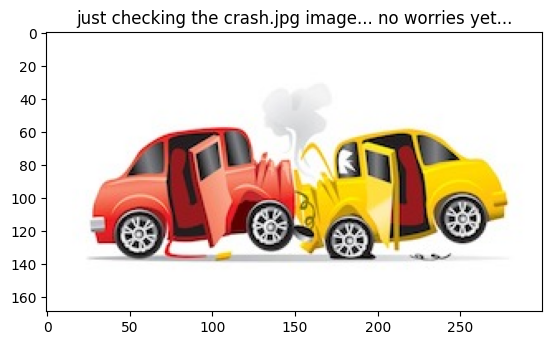

In [11]:
# test codes -to be added to the end of your code
# the SearchInAlphabetSoup() function you wrote will be called several times
# during this test.

# import for imread, just in case
import matplotlib.pyplot as plt
from matplotlib.image import imread
from timeit import default_timer as timer
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random

# get the necessary file
!rm *.jpg 2>/dev/null
!wget https://raw.githubusercontent.com/bugrakoku/data4all/main/crashed.jpg



def GenImage(numLetters = 50, fixedFontSize = True, xCount = 15, yCount = 10, pos = [], cvals = [] ):
    '''
    Input:
        numLetters = maximum number of letters
        fixedFontSize = well doug
        xCount, yCount = number of rows and columns
        pos and cvals = pre-allocated positions of characters

    Output:
        image as numpy array that contains letters randomly located
    '''
    # in the assignment assessment following will not change in test images
    fontname = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
    cellSize = 30 #cell within which a single char will be printed
    BackColor = (255,255, 255) # back color
    ForeColor = (0, 0, 0) # font color
    charz = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
    # in the assignment assessment variable above will not change in generating test images
    fR = 0.8 # font ratio to cell size
    # generate an empty list to be filled in randomly
    #charmap = [['' for i in range(xCount)] for j in range(yCount)] # assign

    fontsize = int(cellSize * fR) # fixed font size
    nB = int(cellSize*(1-fR)) # location noise

    img = Image.new('RGB', (xCount*cellSize,yCount*cellSize), BackColor ) # blank image
    imgPen = ImageDraw.Draw(img) # pen to draw on the blank image

    # first generate random positions over pos
    # note that pos might be already partially filled in
    for i in range(len(pos), numLetters):
        x = np.random.randint(0, xCount)
        y = np.random.randint(0, yCount)
        if [y,x] not in pos:
            pos.append([y,x])
            cvals.append(random.choice(charz))
    print(f'size: {len(pos)}:{len(cvals)}')
    # now that positions are determined, print random letters in them
    for ([y,x], txt) in zip(pos, cvals): # draw each letter if random location is not already occupied, if occupied, skip
        if not fixedFontSize: # if set so, select a random font size
            fontsize = np.random.randint(12, cellSize-1)
            dx, dy = 0, 0 # when scaled, position does not change
        else: # add some location noise
            dx = int(np.random.rand()* nB)
            dy = int(np.random.rand()* nB)
        font = ImageFont.truetype(fontname, fontsize) # font instace created
        imgPen.text((x * cellSize + dx, y * cellSize + dy), txt, font=font, fill=ForeColor) # write the character to blank image


    return np.array(img) # finally return image as an numpy array

test_basic = ['simplest']
test_more = ['simple', 'test50', 'test100']
test_pro = ['test150', 'test250', 'test400', 'testInsane']
test_all = test_basic + test_more + test_pro
# the following are variable font size cases
test_basicF = ['simplestF']
test_moreF = ['simpleF', 'test50F', 'test100F']
test_ProF = ['test150F', 'test250F', 'test400F', 'testInsaneF']
test_allF = test_basicF + test_moreF + test_ProF

def PerformTest(cases = ['simplest'], figSize = (25,25)):
    shapes = ['KARE', 'BUDUR', '6KENAR']
    crash = imread('crashed.jpg')
    imgz = []
    imgTitles = []
    for case in cases:
        img = np.load(f'{case}.npy')
        for shape in shapes:
            startTime = timer()
            try:
                print(f'Searching for {shape} in {case} ')
                imgR = SearchInAlphabetSoup(img.copy(), shape)
                imgz.append(imgR)
            except:
                imgz.append(crash)
            endTime = timer()
            imgTitles.append(f'{shape} in {case}: {round(endTime-startTime, 3)} sec.')
            print(imgTitles[-1])

    # finally plot the results
    fig, axz = plt.subplots(len(imgz), 1, figsize=figSize)
    for i, ax in enumerate(axz):
        ax.imshow(imgz[i])
        ax.set_title(imgTitles[i])

# make suer the crashed image shows up
plt.imshow(plt.imread('crashed.jpg'))
plt.title('just checking the crash.jpg image... no worries yet...')

## Run the following to generate new test cases
If you do not want to use these cases but try a fixed case, check out the zip file downloaded above and use it in testing but during grading you are supposed to use the dynamic case, and I will re-run your graded cases.  

Note that the simplest case is the same with the one in the `zip` file.
Yet the simple case is a bit different.

size: 15:15
size: 15:15
size: 27:27
size: 27:27
size: 50:50
size: 92:92
size: 118:118
size: 188:188
size: 264:264
size: 619:619
size: 48:48
size: 89:89
size: 126:126
size: 191:191
size: 249:249
size: 622:622


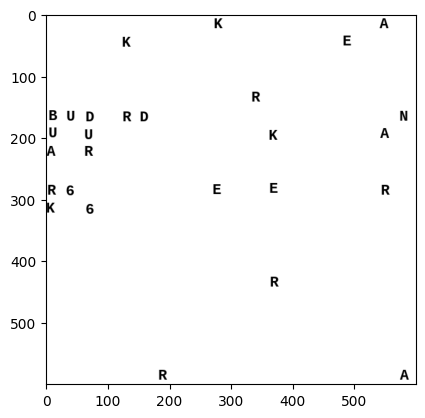

In [12]:
# simplest case
ch = ['K', 'A', 'R', 'E',
      'B', 'U', 'D', 'U', 'R',
      '6', 'K', 'E', 'N', 'A', 'R'
]
pos = [[0,9], [0,13], [4,13], [4, 9],
        [5,0], [5,1], [5,2], [6,2], [7,2],
        [10, 5], [7,7], [7,11], [10, 13 ], [13,11], [13,7],
]
img = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
imgF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
np.save('simplest', img)
np.save('simplestF', imgF)

# simple case
ch = ['K', 'A', 'R', 'E',
      'A', 'R', 'E',
      'B', 'U', 'D', 'U', 'R',
      'U', 'A', 'R', 'K',
      'R', 'D',
      'K', '6', 'R',
      '6', 'K', 'E', 'N', 'A', 'R'
      ]
pos = [[0,9], [0,18], [9,18], [9, 9],
        [6, 18], [4, 11], [9, 12],
        [5,0], [5,1], [5,2], [6,2], [7,2],
        [6,0], [7,0], [9,0], [10,0],
        [5,4], [5,5],
        [6, 12], [10, 2], [14, 12] ]

# add slightly randomized 6KENAR
pos.append([np.random.randint(7, 17), 1]) #6
pos.append([1, np.random.randint(0, 6)]) #K
pos.append([1, np.random.randint(14, 20)]) #E
pos.append([np.random.randint(4, 8), 19]) #N
pos.append([np.random.randint(17, 20), 19]) #A
pos.append([19, np.random.randint(5, 13)]) #R

img = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
imgF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
plt.imshow(img)
np.save('simple', img)
np.save('simpleF', imgF)


# fixed font size cases
img50 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=50)
img100 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=100)
img150 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=150)
img250 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=250)
img400 = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=400)
imgInsane = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=25, yCount=25, numLetters=3000)
np.save('test50', img50)
np.save('test100', img100)
np.save('test150', img150)
np.save('test250', img250)
np.save('test400', img400)
np.save('testInsane', imgInsane)

# variable font size cases
img50F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=50)
img100F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=100)
img150F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=150)
img250F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=250)
img400F = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=400)
imgInsaneF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=25, yCount=25, numLetters=3000)
np.save('test50F', img50F)
np.save('test100F', img100F)
np.save('test150F', img150F)
np.save('test250F', img250F)
np.save('test400F', img400F)
np.save('testInsaneF', imgInsaneF)
#'''

Searching for KARE in simplest 
KARE in simplest: 0.006 sec.
Searching for BUDUR in simplest 
BUDUR in simplest: 0.005 sec.
Searching for 6KENAR in simplest 
6KENAR in simplest: 0.006 sec.
Searching for KARE in simple 
KARE in simple: 0.026 sec.
Searching for BUDUR in simple 
BUDUR in simple: 0.007 sec.
Searching for 6KENAR in simple 
6KENAR in simple: 0.007 sec.
Searching for KARE in test50 
KARE in test50: 0.081 sec.
Searching for BUDUR in test50 
BUDUR in test50: 0.011 sec.
Searching for 6KENAR in test50 
6KENAR in test50: 0.049 sec.
Searching for KARE in test100 
KARE in test100: 1.232 sec.
Searching for BUDUR in test100 
BUDUR in test100: 0.02 sec.
Searching for 6KENAR in test100 
6KENAR in test100: 3.744 sec.
Searching for KARE in test150 
KARE in test150: 0.884 sec.
Searching for BUDUR in test150 
BUDUR in test150: 0.026 sec.
Searching for 6KENAR in test150 
6KENAR in test150: 11.006 sec.
Searching for KARE in test250 
KARE in test250: 10.251 sec.
Searching for BUDUR in test250 

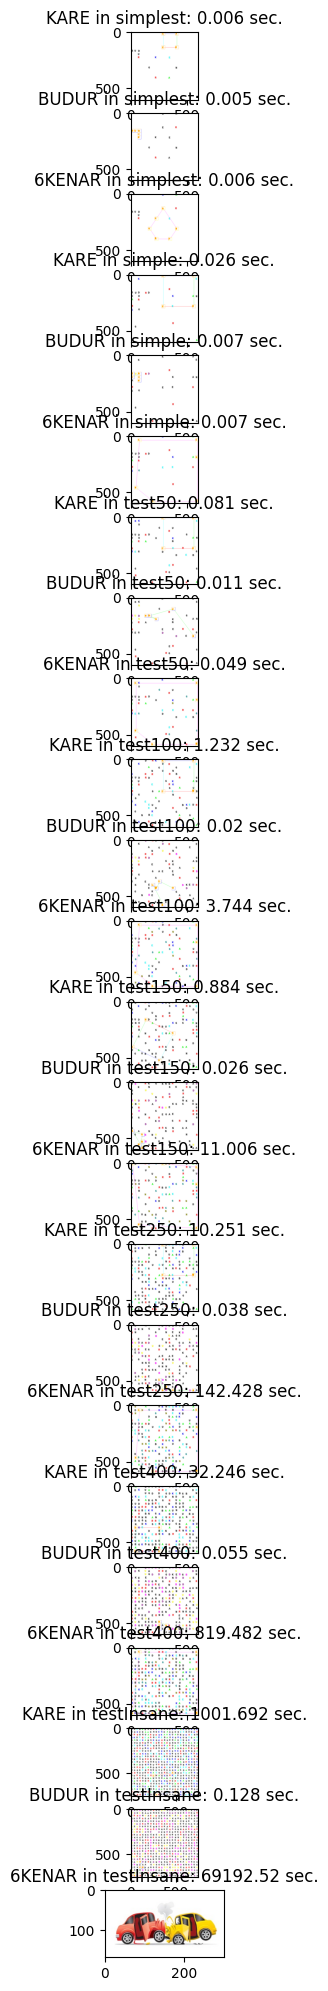

In [10]:
# fixed size font test
# if you trust your code, test them all togather
# or change the following to run one by one try it a few times you will get to the bottom of it
#PerformTest(test_basic)
PerformTest(test_all)

Searching for KARE in simplest 
KARE in simplest: 0.006 sec.
Searching for BUDUR in simplest 
BUDUR in simplest: 0.004 sec.
Searching for 6KENAR in simplest 
6KENAR in simplest: 0.005 sec.


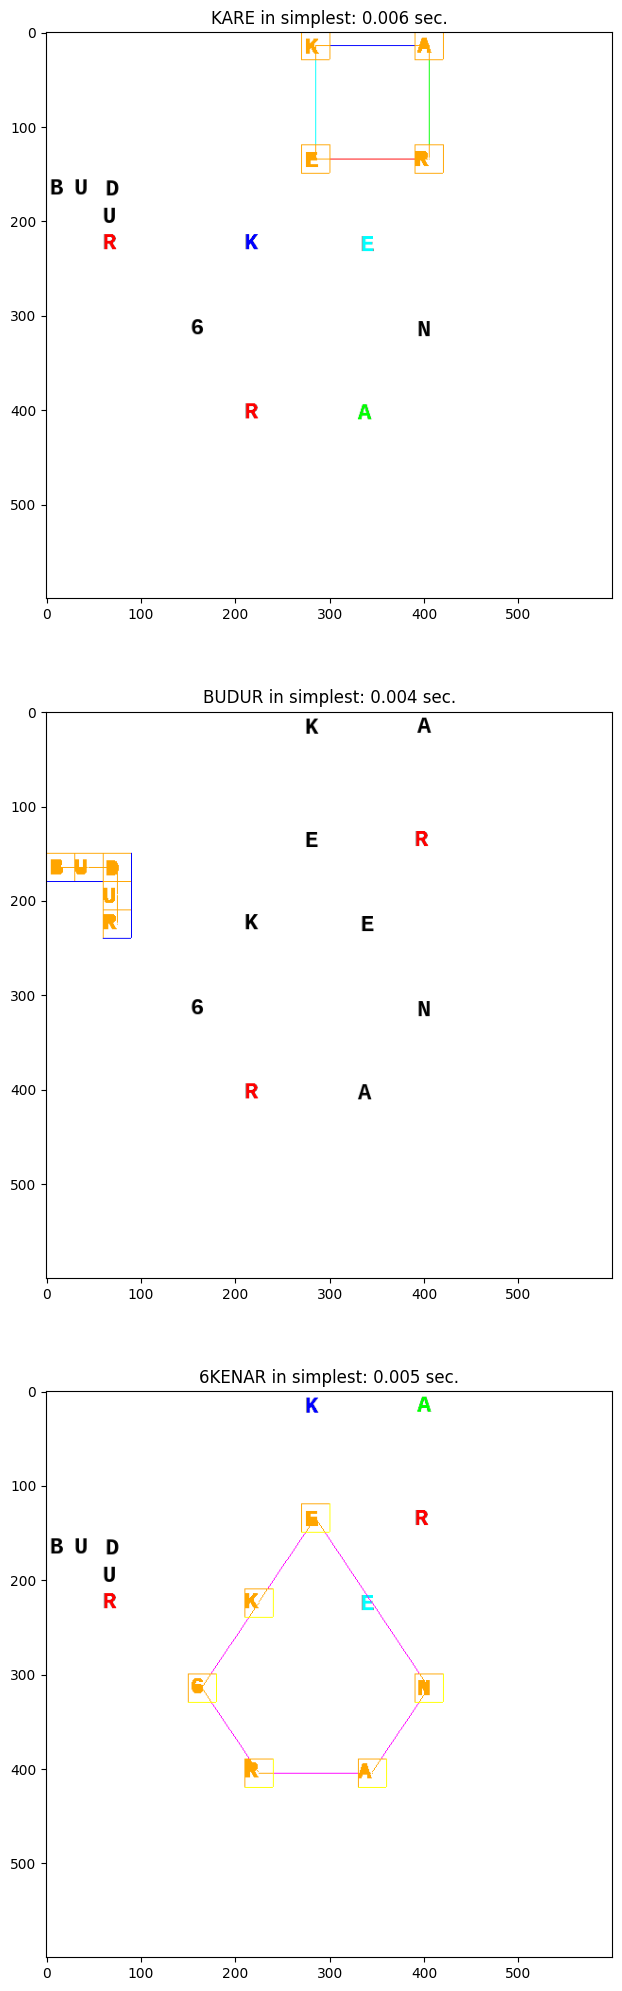

In [11]:
PerformTest(test_basic)

Searching for KARE in simplestF 
KARE in simplestF: 0.007 sec.
Searching for BUDUR in simplestF 
BUDUR in simplestF: 0.004 sec.
Searching for 6KENAR in simplestF 
6KENAR in simplestF: 0.004 sec.


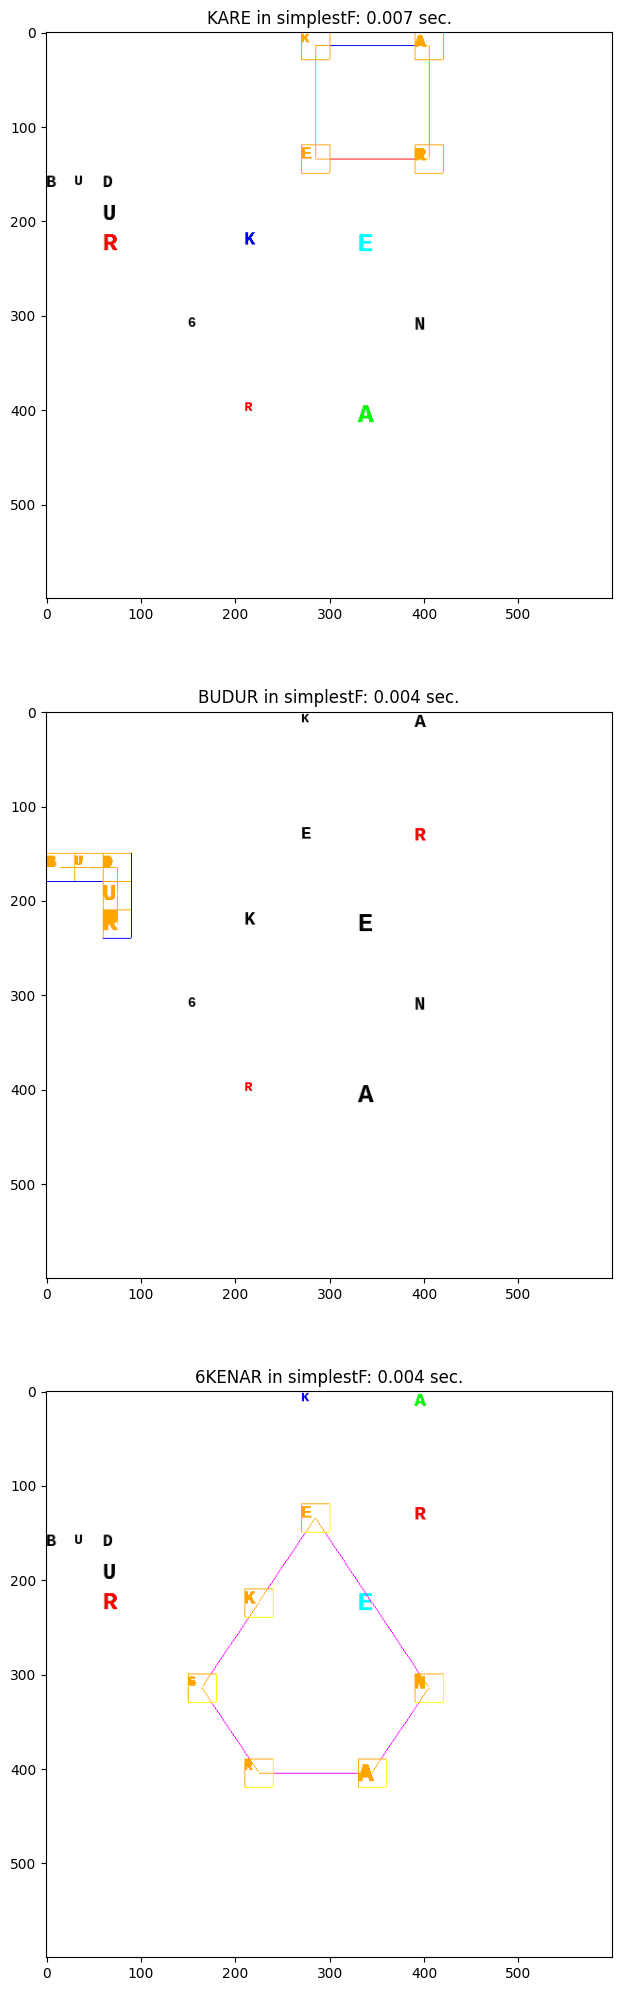

In [12]:
PerformTest(test_basicF)

Searching for KARE in simple 
KARE in simple: 0.022 sec.
Searching for BUDUR in simple 
BUDUR in simple: 0.007 sec.
Searching for 6KENAR in simple 
6KENAR in simple: 0.007 sec.
Searching for KARE in test50 
KARE in test50: 0.081 sec.
Searching for BUDUR in test50 
BUDUR in test50: 0.011 sec.
Searching for 6KENAR in test50 
6KENAR in test50: 0.051 sec.
Searching for KARE in test100 
KARE in test100: 1.214 sec.
Searching for BUDUR in test100 
BUDUR in test100: 0.02 sec.
Searching for 6KENAR in test100 
6KENAR in test100: 3.842 sec.


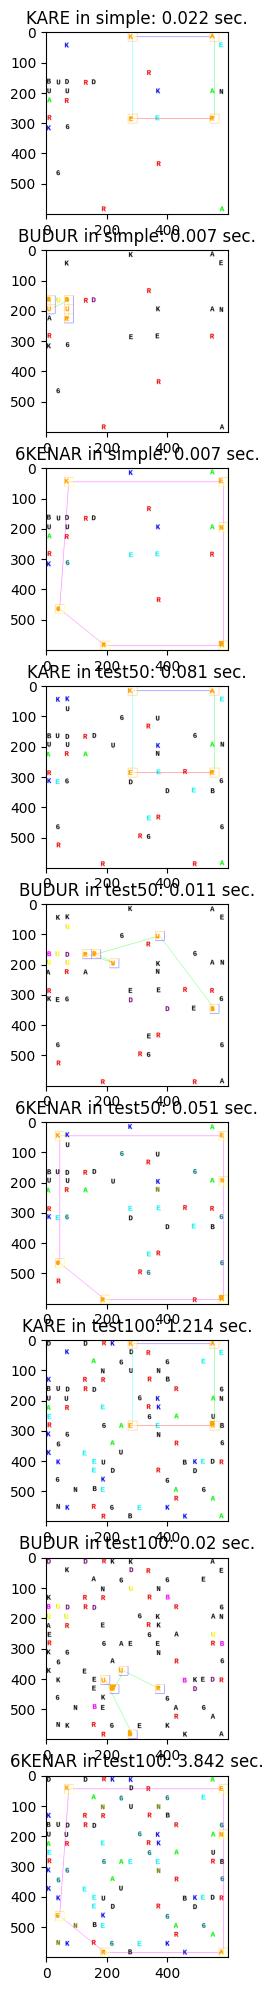

In [13]:
PerformTest(test_more)

Searching for KARE in simpleF 
KARE in simpleF: 0.025 sec.
Searching for BUDUR in simpleF 
BUDUR in simpleF: 0.007 sec.
Searching for 6KENAR in simpleF 
6KENAR in simpleF: 0.008 sec.
Searching for KARE in test50F 
KARE in test50F: 0.068 sec.
Searching for BUDUR in test50F 
BUDUR in test50F: 0.012 sec.
Searching for 6KENAR in test50F 
No valid hexagon configuration found.
6KENAR in test50F: 0.038 sec.
Searching for KARE in test100F 
KARE in test100F: 1.086 sec.
Searching for BUDUR in test100F 
BUDUR in test100F: 0.02 sec.
Searching for 6KENAR in test100F 
6KENAR in test100F: 1.92 sec.


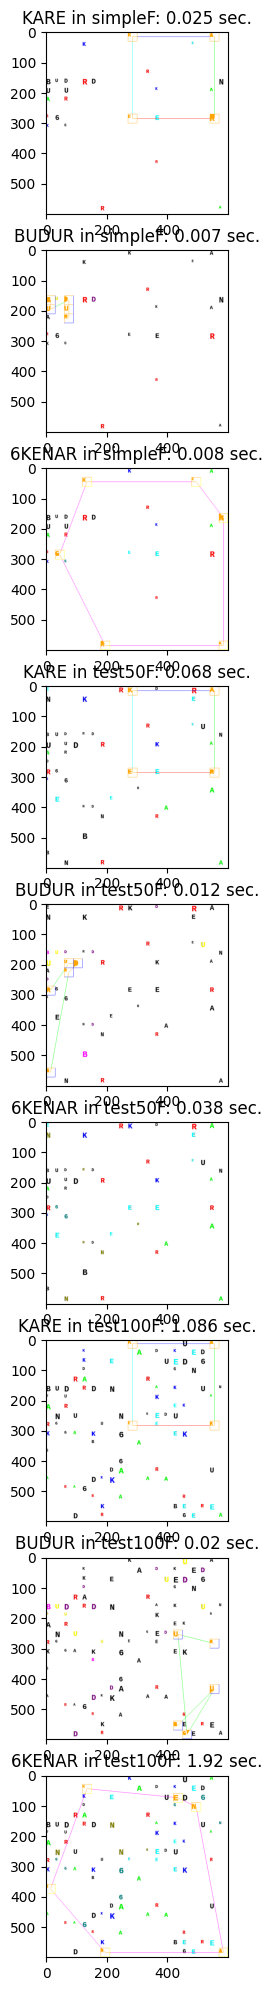

In [13]:
PerformTest(test_moreF)

Searching for KARE in test150 
KARE in test150: 0.866 sec.
Searching for BUDUR in test150 
BUDUR in test150: 0.025 sec.
Searching for 6KENAR in test150 
6KENAR in test150: 11.195 sec.
Searching for KARE in test250 
KARE in test250: 10.304 sec.
Searching for BUDUR in test250 
BUDUR in test250: 0.036 sec.
Searching for 6KENAR in test250 
6KENAR in test250: 145.51 sec.
Searching for KARE in test400 
KARE in test400: 31.866 sec.
Searching for BUDUR in test400 
BUDUR in test400: 0.053 sec.
Searching for 6KENAR in test400 
6KENAR in test400: 761.664 sec.
Searching for KARE in testInsane 
KARE in testInsane: 978.202 sec.
Searching for BUDUR in testInsane 
BUDUR in testInsane: 0.124 sec.
Searching for 6KENAR in testInsane 
6KENAR in testInsane: 457.996 sec.


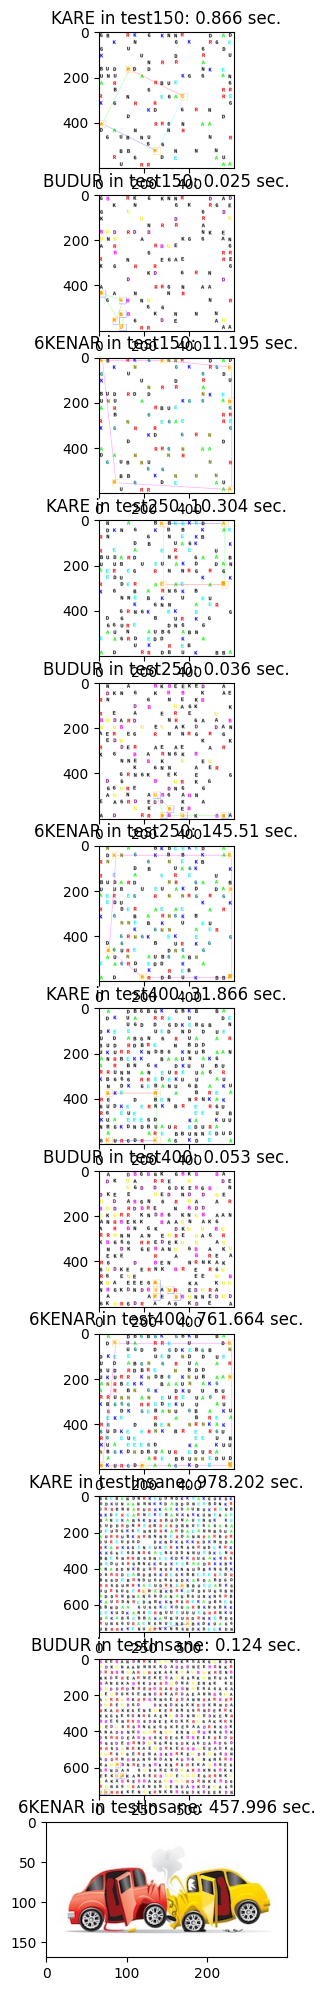

In [16]:
PerformTest(test_pro)

Searching for KARE in test150F 
KARE in test150F: 1.759 sec.
Searching for BUDUR in test150F 
BUDUR in test150F: 0.026 sec.
Searching for 6KENAR in test150F 
6KENAR in test150F: 9.339 sec.
Searching for KARE in test250F 
KARE in test250F: 14.054 sec.
Searching for BUDUR in test250F 
BUDUR in test250F: 0.039 sec.
Searching for 6KENAR in test250F 
6KENAR in test250F: 167.68 sec.
Searching for KARE in test400F 
KARE in test400F: 34.991 sec.
Searching for BUDUR in test400F 
BUDUR in test400F: 0.052 sec.
Searching for 6KENAR in test400F 
6KENAR in test400F: 526.678 sec.
Searching for KARE in testInsaneF 
KARE in testInsaneF: 705.49 sec.
Searching for BUDUR in testInsaneF 
BUDUR in testInsaneF: 0.128 sec.
Searching for 6KENAR in testInsaneF 
6KENAR in testInsaneF: 15.386 sec.


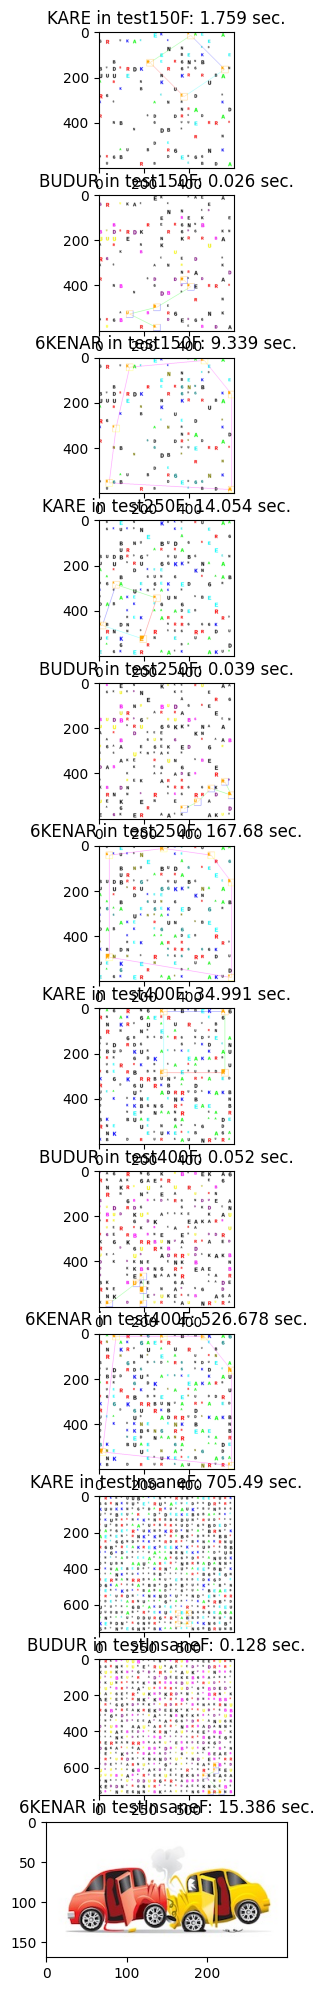

In [14]:
#test_ProF = ['test150F', 'test250F', 'test400F', 'testInsaneF']

PerformTest(test_ProF)

In [ ]:
# variable sized font tests
PerformTest(test_allF)

# Fill in the grades based on the results above and the grading guideline  

Recall that each plot is upto 10 points, hence row totals is 30 points max.  
Under ```Time``` column, enter the time of execution as printed on the title of the relevant plot. As of now, you do not convert execution time to grades, I will asssess it checking out all the submissions later.  



| Case  |  KARE |  BUDUR | 6KENAR  | Time | Total Points |
|---|---|---|---|---|---|
| simplest | 10 | 10 | 10 | 0 | 0 |  
| simple | 0 | 0 | 0 | 0 | 0 |  
| test50 | 0 | 0 | 0 | 0 | 0 |  
| test100 | 0 | 0 | 0 | 0 | 0 |  
| test150 | 0 | 0 | 0 | 0 | 0 |  
| test250 | 0 | 0 | 0 | 0 | 0 |  
| test400 | 0 | 0 | 0 | 0 | 0 |  
| testInsane | 0 | 0 | 0 | 0 | 0 |  
| simplestF | 0 | 0 | 0 | 0 | 0 |  
| simpleF | 0 | 0 | 0 | 0 | 0 |  
| test50F | 0 | 0 | 0 | 0 | 0 |  
| test100F | 0 | 0 | 0 | 0 | 0 |  
| test150F | 0 | 0 | 0 | 0 | 0 |  
| test250F | 0 | 0 | 0 | 0 | 0 |  
| test400F | 0 | 0 | 0 | 0 | 0 |  
| testInsaneF | 0 | 0 | 0 | 0 | 0 |  

Finally enter the sum of Total column and the code edit penalty below:  
**Overall Grade = 0**  

*Recall that maximum possible grade is 480.*  


# What to submit
After adding the above code and text blocks in to your code, run your code, enter the grades into the table, update the grade sum, and submit your notebook **without clearing the outputs!**  
Do not clear the outputs and let your outputs be saved so that I can see how your algorithm performed without running them.  

Yet note that I may check your code with other images!
